In [15]:
using Plots
using LinearAlgebra
using Jacobi
using Test
using SparseArrays

In [16]:
function TrilinearMap(Coord_E, xhat, yhat, zhat)
    """
        local numbering of Hex
    
        5--------7           z
      / |      / |            |
    6 --|---- 8  |            |
    |   |     |  |            /----y
    |   |     |  |           /
    |   1 -------3         x
    | /       | /
    2 --------4
    """
    m = length(xhat)
    N1 = @. 0.125*(1-xhat)*(1-yhat)*(1-zhat)
    N2 = @. 0.125*(1+xhat)*(1-yhat)*(1-zhat)
    N3 = @. 0.125*(1-xhat)*(1+yhat)*(1-zhat)
    N4 = @. 0.125*(1+xhat)*(1+yhat)*(1-zhat)
    N5 = @. 0.125*(1-xhat)*(1-yhat)*(1+zhat)
    N6 = @. 0.125*(1+xhat)*(1-yhat)*(1+zhat)
    N7 = @. 0.125*(1-xhat)*(1+yhat)*(1+zhat)
    N8 = @. 0.125*(1+xhat)*(1+yhat)*(1+zhat)
    N = [N1 N2 N3 N4 N5 N6 N7 N8]
    X = N * Coord_E
    # X(3,m), 1st row x, 2nd row y, 3rd row z
    X = X'
    # derivatives of shape functions with respect to xhat
    dN1_dxhat = @. -0.125*(1-yhat)*(1-zhat)
    dN2_dxhat = -dN1_dxhat
    dN3_dxhat = @. -0.125*(1+yhat)*(1-zhat)
    dN4_dxhat = -dN3_dxhat
    dN5_dxhat = @. -0.125*(1-yhat)*(1+zhat)
    dN6_dxhat = -dN5_dxhat
    dN7_dxhat = @. -0.125*(1+yhat)*(1+zhat)
    dN8_dxhat = -dN7_dxhat

    # derivatives of shape functions with respect to yhat
    dN1_dyhat = @. -0.125*(1-xhat)*(1-zhat)
    dN2_dyhat = @. -0.125*(1+xhat)*(1-zhat)
    dN3_dyhat = -dN1_dyhat
    dN4_dyhat = -dN2_dyhat
    dN5_dyhat = @. -0.125*(1-xhat)*(1+zhat)
    dN6_dyhat = @. -0.125*(1+xhat)*(1+zhat)
    dN7_dyhat = -dN5_dyhat
    dN8_dyhat = -dN6_dyhat

    # derivatives of shape functions with respect to zhat
    dN1_dzhat = @. -0.125*(1-xhat)*(1-yhat)
    dN2_dzhat = @. -0.125*(1+xhat)*(1-yhat)
    dN3_dzhat = @. -0.125*(1-xhat)*(1+yhat)
    dN4_dzhat = @. -0.125*(1+xhat)*(1+yhat)
    dN5_dzhat = -dN1_dzhat
    dN6_dzhat = -dN2_dzhat
    dN7_dzhat = -dN3_dzhat
    dN8_dzhat = -dN4_dzhat
    
    # gradient of N, [dN/dxhat; dN/dyhat; dN/dzhat]
    GradN = zeros(3,m,8)
    GradN[1,:,:] = [dN1_dxhat dN2_dxhat dN3_dxhat dN4_dxhat dN5_dxhat dN6_dxhat dN7_dxhat dN8_dxhat]
    GradN[2,:,:] = [dN1_dyhat dN2_dyhat dN3_dyhat dN4_dyhat dN5_dyhat dN6_dyhat dN7_dyhat dN8_dyhat]
    GradN[3,:,:] = [dN1_dzhat dN2_dzhat dN3_dzhat dN4_dzhat dN5_dzhat dN6_dzhat dN7_dzhat dN8_dzhat]
    
    # JT = [[dx/dxhat, dy/dxhat, dz/dxhat],
    #       [dx/dyhat, dy/dyhat, dz/dyhat],
    #       [dx/dzhat, dy/dzhat, dz/dzhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * Coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    dzdxhat = JTxhat[:,3]
    JTyhat = GradN[2,:,:] * Coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]
    dzdyhat = JTyhat[:,3]
    JTzhat = GradN[3,:,:] * Coord_E
    dxdzhat = JTzhat[:,1]
    dydzhat = JTzhat[:,2]
    dzdzhat = JTzhat[:,3]
    # compute det
    j1 = @. (dxdxhat*dydyhat*dzdzhat + dxdyhat*dydzhat*dzdzhat + dxdzhat*dydxhat*dzdyhat)
    j2 = @. (dxdxhat*dydzhat*dzdyhat + dxdyhat*dydxhat*dzdzhat + dxdzhat*dydyhat*dzdxhat)
    detJ = @. j1 - j2
    
    J = zeros(3,m,3)
    J[1,:,:] = [dxdxhat dxdyhat dxdzhat]
    J[2,:,:] = [dydxhat dydyhat dydzhat]
    J[3,:,:] = [dzdxhat dzdyhat dzdzhat]
    
    return X, J, detJ
end

TrilinearMap (generic function with 1 method)

In [17]:
function GetNormal(Coord_E, xhat, yhat, zhat, face)
    """
    Input:
    Coord_E: coordinate of physical element E as a 8x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    face: that you want the normal
    Note the face and xhat, yhat, zhat should be consistent.
    
    Return:
    n: of size(3,m)
    le: length of n
    
    Based on following numbering:
    left:     nodes 1,2,5,6 at yhat = -1
    right:    nodes 3,4,7,8 at yhat =  1
    bottom:   nodes 1,2,3,4 at zhat = -1
    top:      nodes 5,6,7,8 at zhat =  1
    front:    nodes 2,4,6,8 at xhat =  1
    back:     nodes 1,3,5,7 at xhat = -1
    
    local numbering of Hex
    
        5--------7           z
      / |      / |            |
    6 --|---- 8  |            |
    |   |     |  |            /----y
    |   |     |  |           /
    |   1 -------3         x
    | /       | /
    2 --------4
    """
    X, J, detJ = TrilinearMap(Coord_E, xhat, yhat, zhat)

    dxdxhat = J[1,:,1]
    dxdyhat = J[1,:,2]
    dxdzhat = J[1,:,3]
    
    dydxhat = J[2,:,1]
    dydyhat = J[2,:,2]
    dydzhat = J[2,:,3]
    
    dzdxhat = J[3,:,1]
    dzdyhat = J[3,:,2]
    dzdzhat = J[3,:,3]

    m = length(xhat)
    
    if face == "left" && yhat == -ones(m)
        
        n1 = @. dydxhat*dzdzhat - dzdxhat*dydzhat
        n2 = @. dzdxhat*dxdzhat - dxdxhat*dzdzhat
        n3 = @. dxdxhat*dydzhat - dydxhat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng 
    
    elseif face == "right" && yhat == ones(m)
        
        n1 = @. dzdxhat*dydzhat - dydxhat*dzdzhat
        n2 = @. dxdxhat*dzdzhat - dzdxhat*dxdzhat
        n3 = @. dydxhat*dxdzhat - dxdxhat*dydzhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
        
    elseif face == "bottom" && zhat == -ones(m)
        
        n1 = @. dzdxhat*dydyhat - dydxhat*dzdyhat
        n2 = @. dxdxhat*dzdyhat - dzdxhat*dxdyhat
        n3 = @. dydxhat*dxdyhat - dxdxhat*dydyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
        
    elseif face == "top" && zhat == ones(m)
        
        n1 = @. dydxhat*dzdyhat - dzdxhat*dydyhat 
        n2 = @. dzdxhat*dxdyhat - dxdxhat*dzdyhat 
        n3 = @. dxdxhat*dydyhat - dydxhat*dxdyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
        
    elseif face == "front" && xhat == ones(m)
        
        n1 = @. dydyhat*dzdzhat - dzdyhat*dydzhat
        n2 = @. dzdyhat*dxdzhat - dxdyhat*dzdzhat
        n3 = @. dxdyhat*dydzhat - dydyhat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
        
    elseif face == "back" && xhat == -ones(m)
        
        n1 = @. dzdyhat*dydzhat - dydyhat*dzdzhat 
        n2 = @. dxdyhat*dzdzhat - dzdyhat*dxdzhat
        n3 = @. dydyhat*dxdzhat - dxdyhat*dydzhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng 
    else
        error("face is not defined")
    
    end

    return n, leng
end

GetNormal (generic function with 1 method)

In [18]:
function GetBasis(xhat, yhat, zhat)

    m = length(xhat)
    Bx = zeros(m,24)
    By = zeros(m,24)
    Bz = zeros(m,24)
    Bx[:,1] = @. -0.0625 + -0.125*xhat*yhat + 0.125*xhat*yhat + 0.0625*xhat*xhat;
    By[:,1] = @. -0.0625 + 0.0625*xhat + 0.0625*yhat*yhat + -0.0625*xhat*yhat*yhat;
    Bz[:,1] = @. -0.125 + 0.125*xhat + 0.125*yhat + 0.125*zhat + -0.125*xhat*yhat + 0.125*xhat*yhat*zhat + -0.125*yhat*zhat + -0.125*xhat*zhat;
    Bx[:,2] = @. 0.0625 + -0.125*xhat*yhat + 0.125*xhat*yhat + -0.0625*xhat*xhat;
    By[:,2] = @. -0.0625 + -0.0625*xhat + 0.0625*yhat*yhat + 0.0625*xhat*yhat*yhat;
    Bz[:,2] = @. -0.125 + -0.125*xhat + 0.125*yhat + 0.125*zhat + 0.125*xhat*yhat + -0.125*xhat*yhat*zhat + -0.125*yhat*zhat + 0.125*xhat*zhat;
    Bx[:,3] = @. 0.0625 + 0.125*xhat*yhat + -0.125*xhat*yhat + -0.0625*xhat*xhat;
    By[:,3] = @. 0.0625 + 0.0625*xhat + -0.0625*yhat*yhat + -0.0625*xhat*yhat*yhat;
    Bz[:,3] = @. -0.125 + -0.125*xhat + -0.125*yhat + 0.125*zhat + -0.125*xhat*yhat + 0.125*xhat*yhat*zhat + 0.125*yhat*zhat + 0.125*xhat*zhat;
    Bx[:,4] = @. -0.0625 + 0.125*xhat*yhat + -0.125*xhat*yhat + 0.0625*xhat*xhat;
    By[:,4] = @. 0.0625 + -0.0625*xhat + -0.0625*yhat*yhat + 0.0625*xhat*yhat*yhat;
    Bz[:,4] = @. -0.125 + 0.125*xhat + -0.125*yhat + 0.125*zhat + 0.125*xhat*yhat + -0.125*xhat*yhat*zhat + 0.125*yhat*zhat + -0.125*xhat*zhat;
    Bx[:,5] = @. 0.0625 + -0.0625*zhat + 0.0625*xhat*xhat*zhat + -0.0625*xhat*xhat;
    By[:,5] = @. 0.125 + 0.125*xhat + 0.125*yhat + -0.125*zhat + -0.125*xhat*zhat + -0.125*xhat*yhat*zhat + 0.125*xhat*yhat + -0.125*yhat*zhat;
    Bz[:,5] = @. -0.0625 + -0.125*xhat*zhat + 0.0625*zhat*zhat + 0.125*xhat*zhat;
    Bx[:,6] = @. -0.0625 + 0.0625*zhat + -0.0625*xhat*xhat*zhat + 0.0625*xhat*xhat;
    By[:,6] = @. 0.125 + -0.125*xhat + 0.125*yhat + -0.125*zhat + 0.125*xhat*zhat + 0.125*xhat*yhat*zhat + -0.125*xhat*yhat + -0.125*yhat*zhat;
    Bz[:,6] = @. -0.0625 + 0.125*xhat*zhat + 0.0625*zhat*zhat + -0.125*xhat*zhat;
    Bx[:,7] = @. -0.0625 + -0.0625*zhat + 0.0625*xhat*xhat*zhat + 0.0625*xhat*xhat;
    By[:,7] = @. 0.125 + -0.125*xhat + 0.125*yhat + 0.125*zhat + -0.125*xhat*zhat + -0.125*xhat*yhat*zhat + -0.125*xhat*yhat + 0.125*yhat*zhat;
    Bz[:,7] = @. 0.0625 + 0.125*xhat*zhat + -0.0625*zhat*zhat + -0.125*xhat*zhat;
    Bx[:,8] = @. 0.0625 + 0.0625*zhat + -0.0625*xhat*xhat*zhat + -0.0625*xhat*xhat;
    By[:,8] = @. 0.125 + 0.125*xhat + 0.125*yhat + 0.125*zhat + 0.125*xhat*zhat + 0.125*xhat*yhat*zhat + 0.125*xhat*yhat + 0.125*yhat*zhat;
    Bz[:,8] = @. 0.0625 + -0.125*xhat*zhat + -0.0625*zhat*zhat + 0.125*xhat*zhat;
    Bx[:,9] = @. -0.0625 + -0.125*xhat*yhat + 0.125*xhat*yhat + 0.0625*xhat*xhat;
    By[:,9] = @. -0.0625 + 0.0625*xhat + 0.0625*yhat*yhat + -0.0625*xhat*yhat*yhat;
    Bz[:,9] = @. 0.125 + -0.125*xhat + -0.125*yhat + 0.125*zhat + 0.125*xhat*yhat + 0.125*xhat*yhat*zhat + -0.125*yhat*zhat + -0.125*xhat*zhat;
    Bx[:,10] = @. 0.0625 + -0.125*xhat*yhat + 0.125*xhat*yhat + -0.0625*xhat*xhat;
    By[:,10] = @. -0.0625 + -0.0625*xhat + 0.0625*yhat*yhat + 0.0625*xhat*yhat*yhat;
    Bz[:,10] = @. 0.125 + 0.125*xhat + -0.125*yhat + 0.125*zhat + -0.125*xhat*yhat + -0.125*xhat*yhat*zhat + -0.125*yhat*zhat + 0.125*xhat*zhat;
    Bx[:,11] = @. 0.0625 + 0.125*xhat*yhat + -0.125*xhat*yhat + -0.0625*xhat*xhat;
    By[:,11] = @. 0.0625 + 0.0625*xhat + -0.0625*yhat*yhat + -0.0625*xhat*yhat*yhat;
    Bz[:,11] = @. 0.125 + 0.125*xhat + 0.125*yhat + 0.125*zhat + 0.125*xhat*yhat + 0.125*xhat*yhat*zhat + 0.125*yhat*zhat + 0.125*xhat*zhat;
    Bx[:,12] = @. -0.0625 + 0.125*xhat*yhat + -0.125*xhat*yhat + 0.0625*xhat*xhat;
    By[:,12] = @. 0.0625 + -0.0625*xhat + -0.0625*yhat*yhat + 0.0625*xhat*yhat*yhat;
    Bz[:,12] = @. 0.125 + -0.125*xhat + 0.125*yhat + 0.125*zhat + -0.125*xhat*yhat + -0.125*xhat*yhat*zhat + 0.125*yhat*zhat + -0.125*xhat*zhat;
    Bx[:,13] = @. 0.0625 + -0.0625*zhat + 0.0625*xhat*xhat*zhat + -0.0625*xhat*xhat;
    By[:,13] = @. -0.125 + -0.125*xhat + 0.125*yhat + 0.125*zhat + 0.125*xhat*zhat + -0.125*xhat*yhat*zhat + 0.125*xhat*yhat + -0.125*yhat*zhat;
    Bz[:,13] = @. -0.0625 + -0.125*xhat*zhat + 0.0625*zhat*zhat + 0.125*xhat*zhat;
    Bx[:,14] = @. -0.0625 + 0.0625*zhat + -0.0625*xhat*xhat*zhat + 0.0625*xhat*xhat;
    By[:,14] = @. -0.125 + 0.125*xhat + 0.125*yhat + 0.125*zhat + -0.125*xhat*zhat + 0.125*xhat*yhat*zhat + -0.125*xhat*yhat + -0.125*yhat*zhat;
    Bz[:,14] = @. -0.0625 + 0.125*xhat*zhat + 0.0625*zhat*zhat + -0.125*xhat*zhat;
    Bx[:,15] = @. -0.0625 + -0.0625*zhat + 0.0625*xhat*xhat*zhat + 0.0625*xhat*xhat;
    By[:,15] = @. -0.125 + 0.125*xhat + 0.125*yhat + -0.125*zhat + 0.125*xhat*zhat + -0.125*xhat*yhat*zhat + -0.125*xhat*yhat + 0.125*yhat*zhat;
    Bz[:,15] = @. 0.0625 + 0.125*xhat*zhat + -0.0625*zhat*zhat + -0.125*xhat*zhat;
    Bx[:,16] = @. 0.0625 + 0.0625*zhat + -0.0625*xhat*xhat*zhat + -0.0625*xhat*xhat;
    By[:,16] = @. -0.125 + -0.125*xhat + 0.125*yhat + -0.125*zhat + -0.125*xhat*zhat + 0.125*xhat*yhat*zhat + 0.125*xhat*yhat + 0.125*yhat*zhat;
    Bz[:,16] = @. 0.0625 + -0.125*xhat*zhat + -0.0625*zhat*zhat + 0.125*xhat*zhat;
    Bx[:,17] = @. 0.125 + 0.125*xhat + -0.125*yhat + -0.125*zhat + -0.125*xhat*yhat + -0.125*xhat*yhat + 0.125*yhat*zhat + 0.125*xhat*yhat*zhat;
    By[:,17] = @. -0.0625 + 0.125*yhat*zhat + 0.0625*yhat*yhat + -0.125*yhat*zhat;
    Bz[:,17] = @. -0.0625 + 0.0625*yhat + 0.0625*zhat*zhat + -0.0625*yhat*zhat*zhat;
    Bx[:,18] = @. 0.125 + 0.125*xhat + 0.125*yhat + -0.125*zhat + -0.125*xhat*yhat + 0.125*xhat*yhat + -0.125*yhat*zhat + -0.125*xhat*yhat*zhat;
    By[:,18] = @. 0.0625 + 0.125*yhat*zhat + -0.0625*yhat*yhat + -0.125*yhat*zhat;
    Bz[:,18] = @. -0.0625 + -0.0625*yhat + 0.0625*zhat*zhat + 0.0625*yhat*zhat*zhat;
    Bx[:,19] = @. 0.125 + 0.125*xhat + 0.125*yhat + 0.125*zhat + 0.125*xhat*yhat + 0.125*xhat*yhat + 0.125*yhat*zhat + 0.125*xhat*yhat*zhat;
    By[:,19] = @. 0.0625 + -0.125*yhat*zhat + -0.0625*yhat*yhat + 0.125*yhat*zhat;
    Bz[:,19] = @. 0.0625 + 0.0625*yhat + -0.0625*zhat*zhat + -0.0625*yhat*zhat*zhat;
    Bx[:,20] = @. 0.125 + 0.125*xhat + -0.125*yhat + 0.125*zhat + 0.125*xhat*yhat + -0.125*xhat*yhat + -0.125*yhat*zhat + -0.125*xhat*yhat*zhat;
    By[:,20] = @. -0.0625 + -0.125*yhat*zhat + 0.0625*yhat*yhat + 0.125*yhat*zhat;
    Bz[:,20] = @. 0.0625 + -0.0625*yhat + -0.0625*zhat*zhat + 0.0625*yhat*zhat*zhat;
    Bx[:,21] = @. -0.125 + 0.125*xhat + 0.125*yhat + 0.125*zhat + -0.125*xhat*yhat + -0.125*xhat*yhat + -0.125*yhat*zhat + 0.125*xhat*yhat*zhat;
    By[:,21] = @. -0.0625 + 0.125*yhat*zhat + 0.0625*yhat*yhat + -0.125*yhat*zhat;
    Bz[:,21] = @. -0.0625 + 0.0625*yhat + 0.0625*zhat*zhat + -0.0625*yhat*zhat*zhat;
    Bx[:,22] = @. -0.125 + 0.125*xhat + -0.125*yhat + 0.125*zhat + -0.125*xhat*yhat + 0.125*xhat*yhat + 0.125*yhat*zhat + -0.125*xhat*yhat*zhat;
    By[:,22] = @. 0.0625 + 0.125*yhat*zhat + -0.0625*yhat*yhat + -0.125*yhat*zhat;
    Bz[:,22] = @. -0.0625 + -0.0625*yhat + 0.0625*zhat*zhat + 0.0625*yhat*zhat*zhat;
    Bx[:,23] = @. -0.125 + 0.125*xhat + -0.125*yhat + -0.125*zhat + 0.125*xhat*yhat + 0.125*xhat*yhat + -0.125*yhat*zhat + 0.125*xhat*yhat*zhat;
    By[:,23] = @. 0.0625 + -0.125*yhat*zhat + -0.0625*yhat*yhat + 0.125*yhat*zhat;
    Bz[:,23] = @. 0.0625 + 0.0625*yhat + -0.0625*zhat*zhat + -0.0625*yhat*zhat*zhat;
    Bx[:,24] = @. -0.125 + 0.125*xhat + 0.125*yhat + -0.125*zhat + 0.125*xhat*yhat + -0.125*xhat*yhat + 0.125*yhat*zhat + -0.125*xhat*yhat*zhat;
    By[:,24] = @. -0.0625 + -0.125*yhat*zhat + 0.0625*yhat*yhat + 0.125*yhat*zhat;
    Bz[:,24] = @. 0.0625 + -0.0625*yhat + -0.0625*zhat*zhat + 0.0625*yhat*zhat*zhat;

    B = zeros(3m, 24)
    B[1:m,:] = Bx[1:m,:]
    B[m+1:2*m,:] = By[1:m,:]
    B[2*m+1:3*m,:] = Bz[1:m,:]
    Dhat = zeros(1,24)
    Dhat[1,:] .= 0.125;
    Div = repeat(Dhat, inner=(m,1))
    
    return B, Div
end

GetBasis (generic function with 1 method)

In [19]:
function GetQuadrature3D(Q, quad_mode)
    """ 
    Input:
    Q: number of quadrature points in 1D over [-1,1]
    quad_mode: GAUSS or LOBATTO
    Return:Gauss Quadrature data over [-1,1]^3.
    w: weights of quadrature pts
    qx: quadrature pts in x
    qy: quadrature pts in y
    qz
    """
    
    # 1D Gauss
    if quad_mode == "GAUSS"
        q = zgj(Q, 0.0, 0.0)
        w1 = wgj(q, 0.0, 0.0)
    elseif quad_mode == "LOBATTO"
        q = zglj(Q, 0.0, 0.0)
        w1 = wglj(q, 0.0, 0.0)
    end
    w = zeros(Q*Q*Q)
    qx = zeros(Q*Q*Q)
    qy = zeros(Q*Q*Q)
    qz = zeros(Q*Q*Q)
    for l=1:Q
        for i=1:Q
            for j=1:Q
                k = Q*Q*(l-1) + (i-1)*Q +j
                qx[k] = q[j]
                qy[k] = q[i]
                qz[k] = q[l]
                w[k] = w1[j]*w1[i]*w1[l]
            end
        end
    end
    return w, qx, qy, qz
end

GetQuadrature3D (generic function with 1 method)

# Create rhs qfunction and check with libCEED
$$\int v^T J^T u_e w $$

In [20]:
function VelocityLinear(x, y, z)
    m = length(x)
    ux = @. (x+y+z)
    uy = @. (2*x+2*y+2*z)
    uz = @. (3*x+3*y+3*z)
    
    ue = zeros(3,m)
    ue[1,:] = ux
    ue[2,:] = uy
    ue[3,:] = uz
    return ue
end

function VelocityConstant(x, y, z)
    m = length(x)
    ux = 3
    uy = 4
    uz = 5
    
    ue = zeros(3,m)
    ue[1,:] .= ux
    ue[2,:] .= uy
    ue[3,:] .= uz
    return ue
end

VelocityConstant (generic function with 2 methods)

In [32]:
function GetRhs(Coord_E, Q, quad_mode, uexact)
    
    w, qx, qy, qz = GetQuadrature3D(Q, quad_mode)
    # total number of quadrature points
    num_qpts = Q*Q*Q
    # get (x,y,z) on E, detJ,...
    coords, dxdX, detJ = TrilinearMap(Coord_E, qx, qy, qz)
    x = coords[1,:]
    y = coords[2,:]
    z = coords[3,:]
    
    ue = uexact(x,y,z)
    # output of qfunction
    rhs2 = zeros(3*num_qpts,1)
    for i=1:num_qpts
        J = dxdX[:,i,:]
        uu = ue[:,i]
        rhs1 = J' * uu       
        # component 1
        rhs2[i+0*num_qpts, 1] = rhs1[1] *w[i]
        # component 2
        rhs2[i+1*num_qpts, 1] = rhs1[2] *w[i]
        # component 3
        rhs2[i+2*num_qpts, 1] = rhs1[3] *w[i]
    end 
    
    B, Div = GetBasis(qx, qy, qz);
    # ApplyBasis
    rhs = B' * rhs2
    
    return rhs
end

GetRhs (generic function with 1 method)

In [35]:
Q = 2
C_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.;1. 1. 1.]
mode = "GAUSS"
uexact(x,y,z) = VelocityLinear(x,y,z)
#uexact(x,y,z) = VelocityConstant(x,y)
rhs = GetRhs(C_E, Q, mode, uexact)

24×1 Matrix{Float64}:
  3.2222222222222223
  0.7777777777777776
 -0.7777777777777779
  0.7777777777777779
  0.5555555555555555
 -0.5555555555555559
  0.5555555555555558
  2.111111111111112
 -0.7777777777777779
  0.7777777777777779
  3.222222222222223
  0.7777777777777778
  0.5555555555555556
  2.111111111111112
  0.5555555555555556
 -0.5555555555555559
 -2.220446049250313e-16
 -2.7755575615628914e-17
  1.3333333333333335
  1.1102230246251565e-16
  1.3333333333333335
  1.1102230246251565e-16
  0.0
  8.326672684688674e-17

# Create Local Mass Matrix
$$(v,u_h) = \int \frac{N^T J^T J N w}{detJ} $$

In [88]:
function GetLocalMass(Coord_E, Q, quad_mode)
    
    w, qx, qy = GetQuadrature2D(Q, quad_mode)
    # total number of quadrature points
    num_qpts = Q*Q
    # get (x,y,z) on E, detJ,...
    coords, dxdX, detJ = BilinearMap(Coord_E, qx, qy)
    
    N = GetBasis(qx, qy);
    # output of qfunction
    tmp = zeros(2*num_qpts,8)
    uu = zeros(2,8)
    for i=1:num_qpts
        J = dxdX[:,i,:]
        uu[1,:] = N[i+0*num_qpts,:]
        uu[2,:] = N[i+1*num_qpts,:]
        #J^T * J * N * w / detJ
        tmp2 = J' * J * uu * w[i] /detJ[i]
        # component 1
        tmp[i+0*num_qpts, :] = tmp2[1,:]
        # component 2
        tmp[i+1*num_qpts, :] = tmp2[2,:]
    end 
    
    # ApplyBasis
    Me = N' * tmp
    
    return Me
end

GetLocalMass (generic function with 1 method)

In [89]:
Me = GetLocalMass(C_E, Q, mode)

8×8 Matrix{Float64}:
  0.477778     -0.188889      0.188889     …   1.19398e-17  -0.166667
 -0.188889      0.477778     -0.144444        -0.166667     -2.36356e-17
  0.188889     -0.144444      0.477778         0.166667      9.75782e-18
 -0.144444      0.188889     -0.188889         1.93801e-18   0.166667
  0.166667     -1.3827e-17    2.77048e-17     -0.188889     -0.144444
 -2.01187e-17   0.166667     -0.166667     …  -0.144444     -0.188889
  1.24819e-17  -0.166667      0.166667         0.477778      0.188889
 -0.166667     -8.67362e-18  -5.20417e-18      0.188889      0.477778

# Test Mass matrix

In [90]:
ue = DiscretizeUe(C_E, uexact)
uh = Me \ rhs
@test isapprox(ue, uh;atol=1e-14)

Test Passed

In [91]:
ue

8-element Vector{Float64}:
 0.0
 1.0
 0.0
 1.0
 0.0
 0.0
 1.5
 1.5

This solution is what we expected

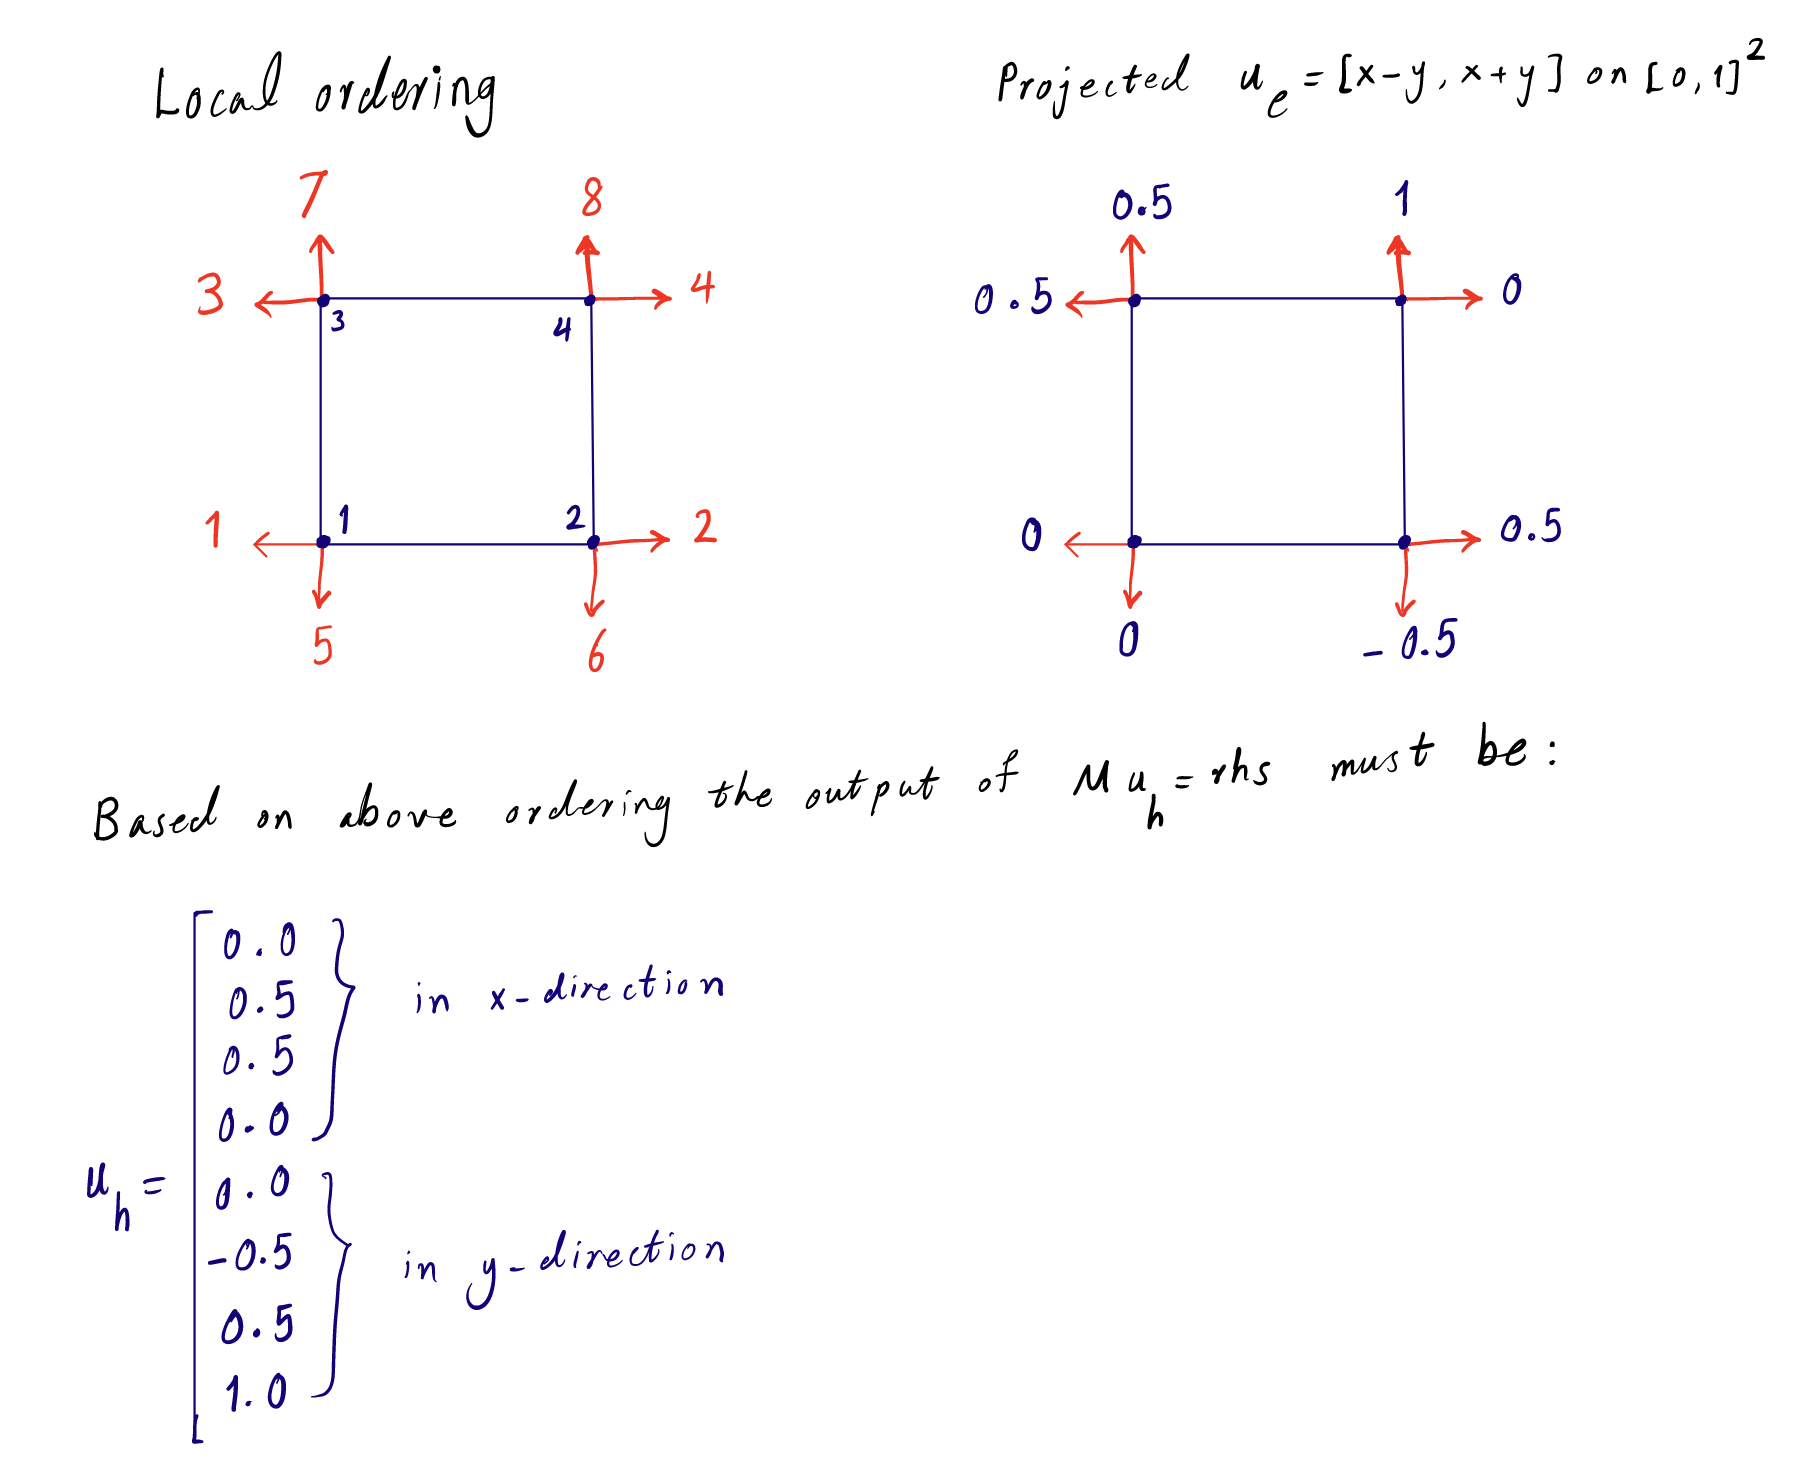

# nx=1, ny=2

In [92]:
C_E1 = [0 0;1 0;0 0.5;1 0.5]
C_E2 = [0 0.5;1 0.5;0 1;1 1]
ue1 = DiscretizeUe(C_E1, uexact)
ue2 = DiscretizeUe(C_E2, uexact)
rhs1 = GetRhs(C_E1, Q, mode, uexact)
rhs2 = GetRhs(C_E2, Q, mode, uexact);

In [93]:
ue1

8-element Vector{Float64}:
 0.0
 0.5
 0.0
 0.5
 0.0
 0.0
 0.75
 0.75

In [94]:
rhs1

8×1 Matrix{Float64}:
 -0.3958333333333335
  0.6041666666666666
 -0.2708333333333332
  0.7291666666666667
 -0.29166666666666674
  0.04166666666666667
  0.08333333333333336
  0.41666666666666674

In [95]:
rhs2

8×1 Matrix{Float64}:
 -0.5208333333333333
  0.4791666666666665
 -0.14583333333333331
  0.8541666666666669
 -0.6666666666666665
 -0.33333333333333337
  0.45833333333333337
  0.7916666666666666

# nx = 2, ny = 1

In [96]:
C_E1 = [0 0;0.5 0;0 1;0.5 1]
C_E2 = [0.5 0;1 0;0.5 1;1 1]
ue1 = DiscretizeUe(C_E1, uexact)
ue2 = DiscretizeUe(C_E2, uexact)
rhs1 = GetRhs(C_E1, Q, mode, uexact)
rhs2 = GetRhs(C_E2, Q, mode, uexact);

In [97]:
ue1

8-element Vector{Float64}:
 0.0
 0.5
 0.0
 0.5
 0.0
 0.0
 0.75
 0.75

In [98]:
ue2

8-element Vector{Float64}:
 -0.5
  1.0
 -0.5
  1.0
  0.0
  0.0
  0.75
  0.75

# nx = 2, ny = 2

In [99]:
C_E1 = [0 0;0.5 0;0 0.5;0.5 0.5]
C_E2 = [0.5 0;1 0;0.5 0.5;1 0.5]
C_E3 = [0 0.5;0.5 0.5;0 1;0.5 1]
C_E4 = [0.5 0.5;1 0.5;0.5 1;1 1]
uexact(x,y) = VelocityLinear(x,y)
ue1 = DiscretizeUe(C_E1, uexact)
ue2 = DiscretizeUe(C_E2, uexact)
ue3 = DiscretizeUe(C_E3, uexact)
ue4 = DiscretizeUe(C_E4, uexact)
ue4

8-element Vector{Float64}:
 -0.25
  0.5
 -0.25
  0.5
 -0.375
 -0.375
  0.75
  0.75

# Multiple Element

In [100]:
function GetConnectivity(nelx, nely)
    """This function returns the connectivity array based on edge
    ----6--------7----
    |       |        |
    3       4        5        
    |       |        |
    ----1--------2----

    2-------5--------6
    |       |        |
    |       |        |
    |       |        |
    1-------2--------3
    local numbering of one element is
    ----4----
    |       |
    3       2
    |       |
    ----1----

    3-------4
    |       |
    |       |
    |       |
    1-------2


    Input:
    ------
    nelx: number of element in x direction start from 1 NOT 0
    nely: number of element in y direction start from 1 NOT 0
    Output:
    ------
    IENe: connectivity array of size 4x(nelx*nely) based on edge numbering
    We need IENe for assembly
    IENn: connectivity array of size 4x(nelx*nely) based on node numbering
    We need IENn for find the coordinate of nodes in assembly
    """
    # number of element
    numelem = nelx*nely
    # number of nodes in x-direction
    nodex = nelx + 1
    # number of nodes in y-direction
    nodey = nely + 1
    IENe = zeros(Int64,4,numelem)
    for j=1:nely
        for i=1:nelx
            ele = (j-1)*nelx + i         
            IENe[1,ele] = i + (j-1)*(nodex+nelx)
            IENe[2,ele] = i + (j-1)*(nodex+nelx) + nodex
            IENe[3,ele] = i + (j-1)*(nodex+nelx) + nelx
            IENe[4,ele] = i + (j-1)*(nodex+nelx) + (nodex+nelx)
        end
    end

    IENn = zeros(Int64,4,numelem)
    for j=1:nely
        for i=1:nelx
            ele = (j-1)*nelx + i
            IENn[1,ele] = i + (j-1)*nodex
            IENn[2,ele] = i + (j-1)*nodex + 1
            IENn[3,ele] = i + (j-1)*nodex + nodex
            IENn[4,ele] = i + (j-1)*nodex + nodex + 1
        end
    end

    return IENe, IENn
end


function GetCoordNodes(mesh, nelx, nely)
    """ This function returns the physical coordinates of the nodes.
    Input:
    ------
    nelx:   integer
            number of elements in the x direction.
    nely:   integer
            number of elements in the y direction.
    mesh: can be unifrom or nonuniform

    Output:
    -------
    x:      float (1d array)
            the coordinate of the node in the x direction
    y:      float (1d array)
            the coordinate of the node in the y direction
    The geometry we are working on is like the following.
    (for nelx = 2, nely = 2)
    6---------7----------8
    |         |   (3)    |
    |   (2)   |      ----5
    |      ---4-----/    |
    3-----/   |   (1)    |
    |         |      ----2
    |   (0)   |     /
    |     ----1----/
    0----/
    There are 4 elements (numbering in parenthesis), and 9 nodes.
    This function returns x,y as 9x2 array for the above mesh.
    """
    nodex = nelx + 1
    nodey = nely + 1
    numnodes = nodex*nodey
    # interior nodes for random mesh
    interiornodex = nelx - 1
    interiornodey = nely - 1
    interiornodes = interiornodex*interiornodey

    hx = 1/nelx
    hy = 1/nely
    h = maximum([hx hy])

    # Divide [0,1] by nodex (mesh in the x direction)
    x0 = LinRange(0, 1, nodex)
    if mesh == "uniform"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end

    else
        error("Enter one of the mesh option: 'unifrom', 'nonuniform', 'stretched', 'random' ")
    end
    
    Coord_Ns = zeros(2, numnodes)
    Coord_Ns[1,:] = x
    Coord_Ns[2,:] = y
    
    return Coord_Ns

end

function plotmesh(mesh, nelx, nely)

    p = plot()
    IENe, IENn = GetConnectivity(nelx, nely)
    Coord_Ns = GetCoordNodes(mesh, nelx, nely)
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    numelem = nelx * nely
    nodes = [1 2 4 3 1]
    xx = zeros(5,1)
    yy = zeros(5,1)
    for i = 1:numelem
        for j =1:5
        xx[j] = x[IENn[nodes[j],i]] 
        yy[j] = y[IENn[nodes[j],i]] 
        end
        plot!(p,xx,yy,color="black",legend=false)
    end
    
    return p
end


function GetID(nelx, nely)
    """
    This function returns an array of global dof of size (2,numedges)
    each edge has 2 dof
    """
    nodex = nelx + 1
    nodey = nely + 1
    numedges = (nodex*nely) + (nodey*nelx)
    ID = zeros(Int64,2,numedges)
    for i=1:numedges
        for j=1:2
            ID[j,i] = 2*(i-1) + j
        end
    end

    return ID
end

function GetCoordElem(Coord_Ns, IENn, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (6,3) array
    """
    # get coordinate of nodes
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    
    ce = IENn[:,e]
    Coord_E = zeros(4,2)
    Coord_E[:,1] = x[ce]
    Coord_E[:,2] = y[ce]
    
    return Coord_E
end

GetCoordElem (generic function with 1 method)

In [157]:
e = 1
nx = 2
ny = 3
Coord_Ns = GetCoordNodes("uniform", nx, ny)
IENe, IENn = GetConnectivity(nx, ny)
C_E = GetCoordElem(Coord_Ns, IENn, e)
uexact(x,y) = VelocityLinear(x,y)
ue = DiscretizeUe(C_E, uexact)

8-element Vector{Float64}:
  0.0
  0.08333333333333333
 -0.05555555555555555
  0.13888888888888887
  0.0
 -0.125
 -0.08333333333333333
  0.04166666666666667

In [136]:
C_E

4×2 Matrix{Float64}:
 0.0  0.666667
 0.5  0.666667
 0.0  1.0
 0.5  1.0

# libCEED error for mass matrix

In [6]:
lib_h = [1, 1/2, 1/4, 1/8]
lib_proj = [5.639729e-15, 4.037011e-15, 3.797145e-15, 7.239074e-15]
lib_L2 = [3.073480e-01,8.978215e-02,2.344977e-02,5.942628e-03]

4-element Vector{Float64}:
 0.307348
 0.08978215
 0.02344977
 0.005942628

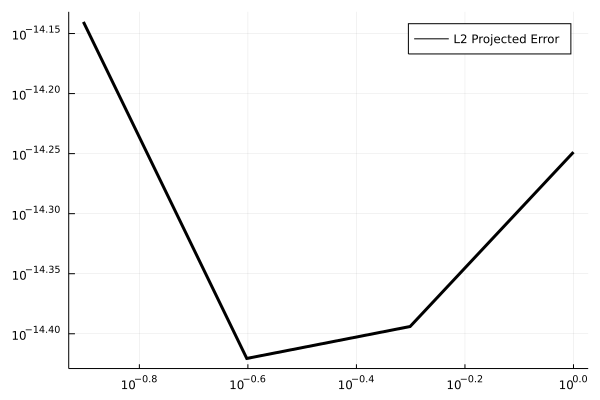

In [7]:
plot(lib_h, lib_proj, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="black", label = "L2 Projected Error")


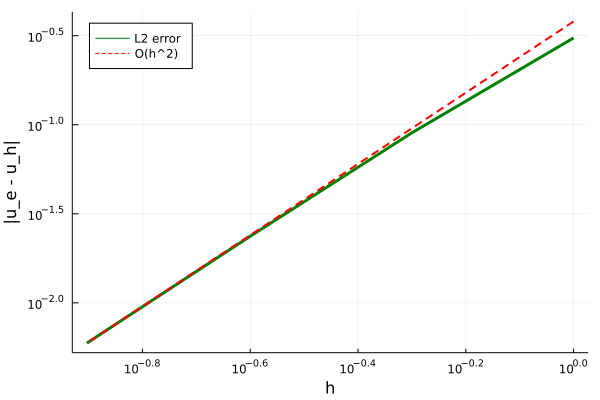

In [8]:
lib_h2 = lib_L2[end]*(lib_h/lib_h[end]).^2
plot(lib_h, lib_L2, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="green", label = "L2 error")
plot!(lib_h, lib_h2, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="red", label = "O(h^2)", legend=:topleft)
xlabel!("h")
ylabel!("|u_e - u_h|")

# libCEED error for mixed form

In [11]:
hh = [1/2, 1/4, 1/8, 1/16]
e_u = [3.086019e-02,1.086231e-02, 4.722052e-03, 2.210292e-03]
e_p = [2.087989e-02,8.620753e-03, 3.430090e-03, 1.635457e-03]

4-element Vector{Float64}:
 0.02087989
 0.008620753
 0.00343009
 0.001635457

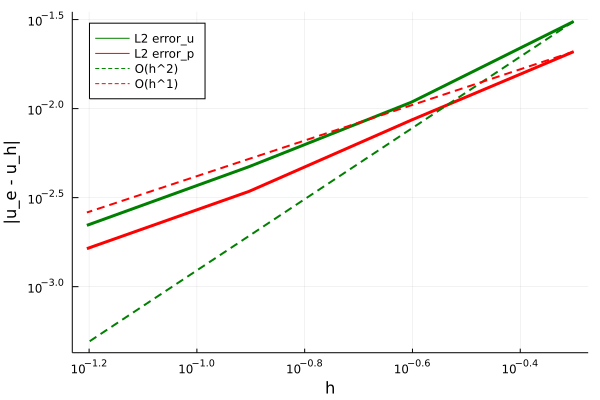

In [13]:
hh2 = e_u[1]*(hh/hh[1]).^2
hh1 = e_p[1]*(hh/hh[1]).^1
plot(hh, e_u, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="green", label = "L2 error_u")
plot!(hh, e_p, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="red", label = "L2 error_p")
plot!(hh, hh2, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="green", label = "O(h^2)")
plot!(hh, hh1, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="red", label = "O(h^1)", legend=:topleft)

xlabel!("h")
ylabel!("|u_e - u_h|")

In [14]:
hh = [1/2, 1/4, 1/8, 1/16]
e_u = [5.067753e-02,9.778260e-03,2.102714e-03, 4.884677e-04]
e_p = [2.276976e-02,8.199986e-02,2.371789e-01, 5.177015e-01]

4-element Vector{Float64}:
 0.02276976
 0.08199986
 0.2371789
 0.5177015

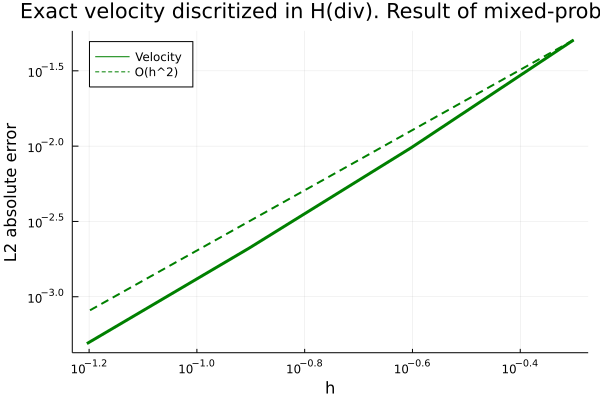

In [20]:
hh2 = e_u[1]*(hh/hh[1]).^2
hh1 = e_p[1]*(hh/hh[1]).^1
plot(hh, e_u, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="green", label = "Velocity")
#plot!(hh, e_p, xaxis=:log, yaxis=:log, lw = 3, linestyles = :solid, color="red", label = "L2 error_p")
plot!(hh, hh2, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="green", label = "O(h^2)",legend=:topleft)
#plot!(hh, hh1, xaxis=:log, yaxis=:log, lw = 2, linestyles = :dash, color="red", label = "O(h^1)", legend=:topleft)
xlabel!("h")
ylabel!("L2 absolute error")
title!("Exact velocity discritized in H(div). Result of mixed-problem")